In [1]:
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd
import datetime
import time 
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb
import warnings
import networkx as nx
import pdb
import pickle

In [2]:
traincsv = pd.read_csv('C:/Users/ADMIN/PROJECT/data/train.csv')

In [3]:
g=nx.read_edgelist('C:/Users/ADMIN/PROJECT/data/fea_sample/after_eda/train_woheader.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
print(nx.info(g))

Name: 
Type: DiGraph
Number of nodes: 1862220
Number of edges: 9437519
Average in degree:   5.0679
Average out degree:   5.0679


Name: 
Type: DiGraph
Number of nodes: 66
Number of edges: 50
Average in degree:   0.7576
Average out degree:   0.7576


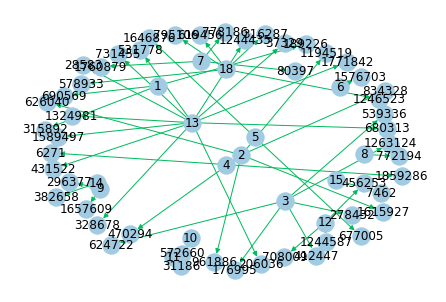

In [4]:
pd.read_csv('C:/Users/ADMIN/PROJECT/data/train.csv', nrows=50).to_csv('train_woheader_sample.csv',header=False,index=False)
subgraph=nx.read_edgelist('train_woheader_sample.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
pos=nx.spring_layout(subgraph)
nx.draw(subgraph,pos,node_color='#A0CBE2',edge_color='#00bb5e',width=1,edge_cmap=plt.cm.Blues,with_labels=True)
plt.savefig("graph_sample.pdf")
print(nx.info(subgraph))

1. Exploratory Data Analysis

In [5]:
# No of Unique persons 
print("The number of unique persons",len(g.nodes()))

The number of unique persons 1862220


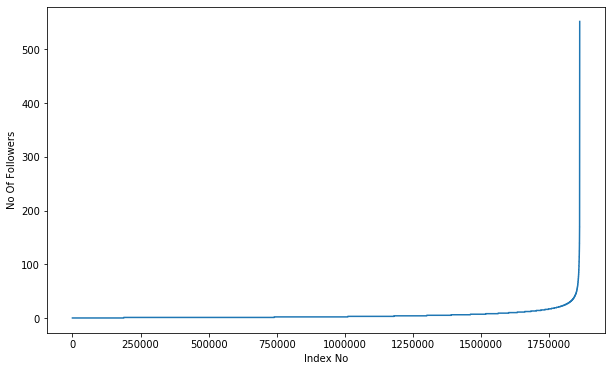

In [6]:
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist)
plt.xlabel('Index No')
plt.ylabel('No Of Followers')
plt.show()

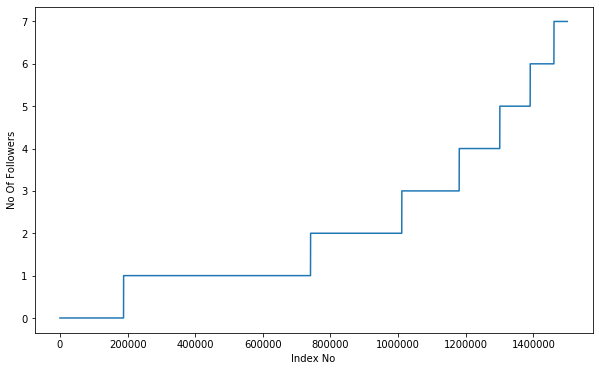

In [7]:
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(indegree_dist[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of Followers')
plt.show()

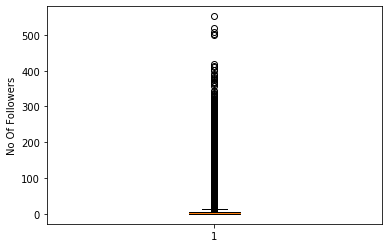

In [8]:
plt.boxplot(indegree_dist)
plt.ylabel('No Of Followers')
plt.show()

1.2 No of people each person is following

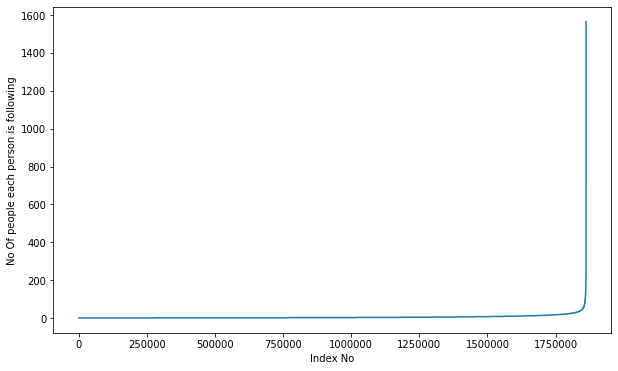

In [9]:
outdegree_dist = list(dict(g.out_degree()).values())
outdegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist)
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following')
plt.show()

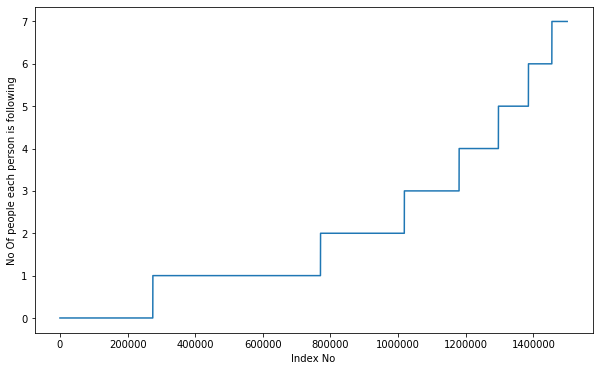

In [10]:
indegree_dist = list(dict(g.in_degree()).values())
indegree_dist.sort()
plt.figure(figsize=(10,6))
plt.plot(outdegree_dist[0:1500000])
plt.xlabel('Index No')
plt.ylabel('No Of people each person is following')
plt.show()

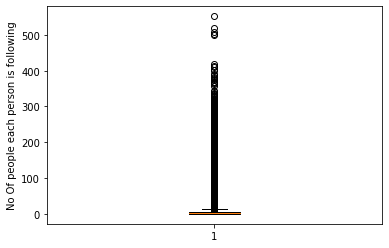

In [11]:
plt.boxplot(indegree_dist)
plt.ylabel('No Of people each person is following')
plt.show()

## Generating some edges which are not present in graph for supervised learning

In [17]:
%%time
import random
if not os.path.isfile('C:/Users/ADMIN/PROJECT/data/fea_sample/after_eda/missing_edges_final.p'):
    #getting all set of edges
    r = csv.reader(open('C:/Users/ADMIN/PROJECT/data/fea_sample/after_eda/train_woheader.csv','r'))
    edges = dict()
    for edge in r:
        edges[(edge[0], edge[1])] = 1
        
        
    missing_edges = set([])
    while (len(missing_edges)<9437519):
        a=random.randint(1, 1862220)
        b=random.randint(1, 1862220)
        tmp = edges.get((a,b),-1)
        if tmp == -1 and a!=b:
            try:
                if nx.shortest_path_length(g,source=a,target=b) > 2: 

                    missing_edges.add((a,b))
                else:
                    continue  
            except:  
                    missing_edges.add((a,b))              
        else:
            continue
    pickle.dump(missing_edges,open('C:/Users/ADMIN/PROJECT/data/fea_sample/after_eda/missing_edges_final.p','wb'))
else:
    missing_edges = pickle.load(open('C:/Users/ADMIN/PROJECT/data/fea_sample/after_eda/missing_edges_final.p','rb'))

Wall time: 6.98 s


## Training and Test data split:
     
     Removed edges from Graph and used as test data and after removing used that graph for creating features for Train and test data

In [3]:
from sklearn.model_selection import train_test_split
if (not os.path.isfile('C:/Users/ADMIN/PROJECT/data/fea_sample/after_eda/train_pos_after_eda.csv')) and (not os.path.isfile('C:/Users/ADMIN/PROJECT/data/fea_sample/after_eda/test_pos_after_eda.csv')):
    #reading total data df
    df_pos = pd.read_csv('C:/Users/ADMIN/PROJECT/data/train.csv')
    df_neg = pd.DataFrame(list(missing_edges), columns=['source_node', 'destination_node'])
    
    print("Number of nodes in the graph with edges", df_pos.shape[0])
    print("Number of nodes in the graph without edges", df_neg.shape[0])
    
    #Trian test split 
    #Spiltted data into 80-20 
    #positive links and negative links seperatly because we need positive training data only for creating graph 
    #and for feature generation
    X_train_pos, X_test_pos, y_train_pos, y_test_pos  = train_test_split(df_pos,np.ones(len(df_pos)),test_size=0.2, random_state=9)
    X_train_neg, X_test_neg, y_train_neg, y_test_neg  = train_test_split(df_neg,np.zeros(len(df_neg)),test_size=0.2, random_state=9)
    
    print('='*60)
    print("Number of nodes in the train data graph with edges", X_train_pos.shape[0],"=",y_train_pos.shape[0])
    print("Number of nodes in the train data graph without edges", X_train_neg.shape[0],"=", y_train_neg.shape[0])
    print('='*60)
    print("Number of nodes in the test data graph with edges", X_test_pos.shape[0],"=",y_test_pos.shape[0])
    print("Number of nodes in the test data graph without edges", X_test_neg.shape[0],"=",y_test_neg.shape[0])

    #removing header and saving
    X_train_pos.to_csv('data/fea_sample/after_eda/train_pos_after_eda.csv',header=False, index=False)
    X_test_pos.to_csv('data/fea_sample/after_eda/test_pos_after_eda.csv',header=False, index=False)
    X_train_neg.to_csv('data/fea_sample/after_eda/train_neg_after_eda.csv',header=False, index=False)
    X_test_neg.to_csv('data/fea_sample/after_eda/test_neg_after_eda.csv',header=False, index=False)
else:
    #Graph from Traing data only 
    del missing_edges

NameError: name 'os' is not defined